## Importing and definitions section



Import the packages.

In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.constants as cs
import scipy 
from scipy import signal
from cmath import phase
import matplotlib.colors as mcolors

The function `mat_diag(k,g_max,V_G_G,M,a)` creates the matrix which corresponds to the Schroedinger equation in $k$-space. The parameters are:   

*   `k`: wavevector in the first Brillouin zone,
*   `g_max`: maximum reciprocal lattice vector taken in the expasion
*   `M` (kg): mass of the particle
*   `a` (m): lattice constant.

Note: the output matrix is expressed in (eV).

In [ ]:
def mat_diag(k_list,g_max,V_G_G,M,a):
	g_dim = 2*np.pi/a
	num_k_list = np.shape(k_list)[0]
	matr = np.zeros((2*g_max+1,2*g_max+1, num_k_list), dtype="complex")
	for k_ind, k in enumerate(k_list):
		for i in range(np.shape(matr)[0]):
			for j in range(np.shape(matr)[1]):
				if i==j:#########      Diagonal terms  [(k+nG) ..... (k) ..... (k-nG)]
					matr[i,j,k_ind] = (cs.hbar)**2*(k+(g_max-i)*g_dim)**2/(2*M*cs.e)
				else:          ##### off diagonal terms
					if j>i:
						matr[i,j,:] = V_G_G[(j-i)]
	return matr

Here we give an example of the matrix constructred with `g_max`=2. Since the matrix is assumed to be Hermitian, only one non-diagonal side must be explicited. 

\begin{bmatrix}
\frac{\hbar^2|k+2G|^2}{2M} & V_1 & V_2&V_3&V_4\\
0 & \frac{\hbar^2|k+G|^2}{2M} & V_1&V_2&V_3\\
0 & 0 & \frac{\hbar^2|k|^2}{2M}&V_1&V_2 \\
0 &0 & 0 & \frac{\hbar^2|k-G|^2}{2M}&V_1 \\
0&0& 0 & 0 & \frac{\hbar^2|k-2G|^2}{2M}
\end{bmatrix}

The function `get_bands(k,mat)` calculates the eigenvalues (energies) of `mat`.

In [ ]:
def get_bands(mat):
	mat_dim = np.shape(mat)[0]       # matrix dimension, it corresponds to 2*g_max+1
	num_k = np.shape(mat)[2]         # number of k points calculated
	bands = np.zeros((num_k,mat_dim))
	losses = np.zeros((num_k,mat_dim ))
	coeff_wavef = np.zeros((num_k,mat_dim,mat_dim ), dtype="complex")
	for k in range(num_k):
		eigv, eigvec = la.eigh(mat[:,:,k],UPLO='U')
		bands[k,:] = np.real(eigv)
		losses[k,:] = np.imag(eigv)
		coeff_wavef[k,:,:] = eigvec	
	return bands, losses, coeff_wavef

`wavef(k_arr,k_ind,n_ind,x,coeff,period)` retrieves the wavefunction for given wavevector $k$ and band index $n$. The parameters are:   

*   `k_arr`: array with the wavevector,
*   `k_ind`: wavevector index
*   `n_index` : band index (starts from 0) 
*   `x` : array of position in real space
*   `coeff`: coefficients which come from the diagonalisation of the matrix, see `get_bands` output.
*    `period`: period of the potential


In [ ]:
def wavef(k_arr,k_ind,n_ind,x,coeff,period):
	len_x = np.shape(x)[0]
	len_k = np.shape(coeff)[1]
	g_maximum = (len_k-1)//2
	func = np.zeros((len_x), dtype="complex")
	for i, c_k in enumerate(coeff[k_ind,:,n_ind]):
		g_ind = (g_maximum-i)
		func += c_k*np.exp(1j*(k_arr[k_ind]+g_ind*2*np.pi/period)*x)
	return func

The function `Fourier_pot(V,g_max)` gives the the complex Fourier expansion coefficients $c_n$ with $n\geq 0$. Since the the potential is real $c_k=c_{-k}^*$, thus the negative terms are redundant. The coefficients are calculated as:

> $c_k= \frac{2}{N} \sum_{n=0}^{N-1} V(x[n]) e^{-i 2\pi \frac{kn}{N}n} $.

See https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html.



With the function `inverse` we calculate the inverse Fourier transform, this will give a rough idea of the goodness of the truncation. The inverse trasform is calculated from the complex coefficients $c_n$ as:

> $V_\text{approx}(x)= \sum_{n=0}^{\text{g_max}}\Re{(c_n)}\cos(\frac{2\pi n}{a}x)-\Im{(c_n)}\sin(\frac{2\pi n}{a}x)$.

In [ ]:
def inverse(dim_real, Pot_coeff): ## We manually construct the inverse transform
	itf = np.zeros(dim_real)
	for n,coeff_pot in enumerate(V_coeff):
		itf += np.real(coeff_pot)*np.cos(2*np.pi*n/a*x)-np.imag(coeff_pot)*np.sin(2*np.pi*n/a*x)
	return itf

In [ ]:
def Fourier_pot(V,g_max):
	dim = np.shape(V)[0]
	ft = scipy.fft.rfft(V)/dim*2
	V_coeff = ft[0:2*g_max+1]   
	V_coeff[0]=V_coeff[0]/2   
	return V_coeff  

Definition of potential forms:

1.   square potential
2.   triangular potential.





In [ ]:
def square(x_arr, fill_f,off, V_maximum):
	dim_x = np.shape(x_arr)[0]
	V = np.zeros(dim_x)
	V[int(dim_x*offset):int(dim_x*(offset+fill_f))] = V_maximum
	return V

In [ ]:
def triangular(x_arr,a, V_maximum):
	dim_x = np.shape(x_arr)[0]
	V = V_maximum*(a/2-np.abs(x-a/2))*2/a
	return V

## Constants and potential definition

Now we define some costants and initialise some arrays.

In [ ]:
num_k = 201     #number of k points in BZ
g_max = 20    # max reciporcal lattice vector in units of 2*pi/a
a= 5*10**(-10)  #lattice constant
M = cs.m_e      #mass
dim = 4096*8      # division in real space of the potential
x=np.linspace(0,a,dim)  # x points of unit cell in real space 
V_max = 0.8
fill_fraction = 0.8
offset = 0.4

In [ ]:
V = square(x,fill_fraction,offset,V_max)
#V = triangular(x,a,V_max)
 
V_coeff = Fourier_pot(V,g_max)
itf = inverse(dim, V_coeff)
k=np.linspace(-np.pi/a,np.pi/a,num_k)

## Bands calculations

In [ ]:
mat_prova = mat_diag(k,g_max,V_G_G=V_coeff, M=M, a=a)
bands, losses, coeff_wave_arr = get_bands(mat_prova)

In [ ]:
n = 1          # band index for the wavefunction 
k_index = 200     # k index for the wavefunction 
func = wavef(k,k_index,n,x,coeff_wave_arr,a)
prob_dens = np.abs(func)**2
norm_dens = np.max(prob_dens)
n_2 = 0
func_2 = wavef(k,k_index,n_2,x,coeff_wave_arr,a)
prob_dens_2 = np.abs(func_2)**2
norm_dens_2 = np.max(prob_dens_2)

## Plots

And finally, the plots. We start with the potential and its approximated form, then we plot the energy bands.

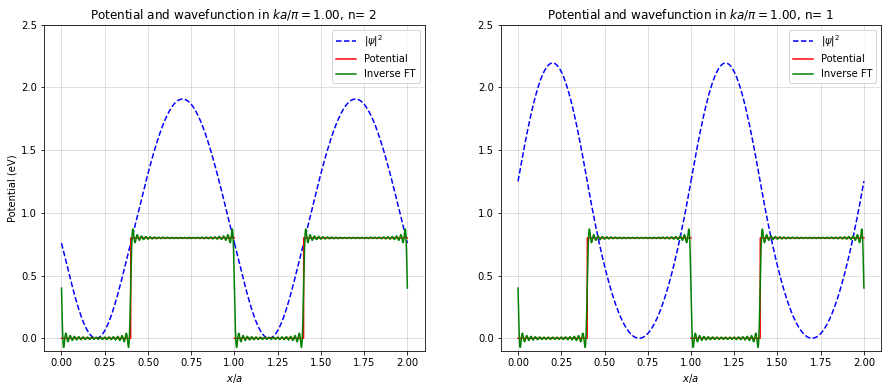

In [ ]:
fig, ax = plt.subplots(1,2,figsize=[15,6])
ax[0].set_title(f"Potential and wavefunction in $k a/\\pi=${k[k_index]*a/np.pi:.2f}, n= {n+1} ")
ax[0].plot(x/a, prob_dens,"--", label="$|\\psi|^2$", color="blue")
ax[0].plot(x/a+1, prob_dens,"--", color="blue")

ax[1].set_title(f"Potential and wavefunction in $k a/\\pi=${k[k_index]*a/np.pi:.2f}, n= {n_2+1} ")
ax[1].plot(x/a, prob_dens_2,"--", label="$|\\psi|^2$", color="blue")
ax[1].plot(x/a+1, prob_dens_2,"--", color="blue" )

#plt.plot(x/a, np.real(func),"-.", label="Re($\\psi$)", color="indigo", lw=1)
#plt.plot(x/a+1, np.real(func),"-.", color="indigo",lw=1)
#plt.plot(x/a, np.imag(func),"-.", label="Im($\\psi$)",color="fuchsia",lw=1)
#plt.plot(x/a+1, np.imag(func),"-.",color="fuchsia",lw=1)
ax[0].plot(x/a,V,label="Potential", color="red")
ax[0].plot(x/a+1,V, color="red")
ax[0].plot(x/a,itf,label="Inverse FT", color="green")
ax[0].plot(x/a+1,itf, color="green")
ax[0].grid(alpha=0.5)
ax[0].legend()
ax[0].set_xlabel("$x/a$")
ax[0].set_ylabel("Potential (eV)")
ax[0].set_ylim([-0.1,2.5])

ax[1].plot(x/a,V,label="Potential", color="red")
ax[1].plot(x/a+1,V, color="red")
ax[1].plot(x/a,itf,label="Inverse FT", color="green")
ax[1].plot(x/a+1,itf, color="green")
ax[1].grid(alpha=0.5)
ax[1].legend()
ax[1].set_xlabel("$x/a$")
ax[1].set_ylim([-0.1,2.5])
plt.show()

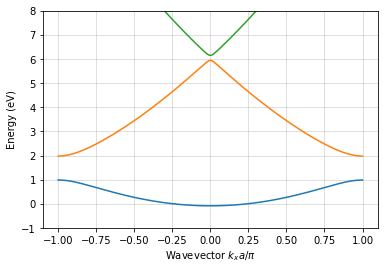

In [ ]:
plt.ylabel("Energy (eV)")
plt.xlabel("Wavevector $k_xa/\\pi$")
plt.plot(k*a/np.pi,bands)
plt.ylim((-1,8))
plt.grid(alpha=0.5)
plt.show()